# Binary And Multiclass Classification with Convolutional Neural Networks

## Business Overview 

For the binary classification portion of this notebook, the business use case is identical to the one stated in the artificial neural network notebook. Convolutional neural networks are more suited for image classification tasks, and they will likely perform better than the artificial neural networks. The results of the previous A.N.N.s will serve as a baseline comparison to the results here. 

The second component of this notebook is to explore the effectiveness of convolutional neural networks when the task is multiclass instead of binary. Since C.N.N.s are designed for image classification, they will hopefully be able to not only determine which images contain defects, but specifically identify which class of defect is present. If viable, multiclass classification would give engineers designing the production pipeline significantly more options for deployment. As the steel moved through the manufacturing line, the pieces could be sorted by defect class, and dealt with accordingly. If some defects are acceptable, they could be allowed through to further processing steps while pieces with other classes of defect were removed. This is a classic implementation of computer vision in a manufacturing environment. 

## Importing the relevant libraries

In [1]:
# Importing the relevant packages
import s3fs

import random as rn
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.utils.np_utils import to_categorical
from keras.models import Sequential 
from keras import layers
from keras.layers import Dense
from keras.regularizers import l2

from sklearn.model_selection import train_test_split

seed = 6
np.random.seed(6)
rn.seed(6)
tf.random.set_seed(6)

Using TensorFlow backend.


## Importing and Reshaping the Image Arrays

Since we already preprocessed our images in the last notebook, here we simply import the image arrays. They are currently all 1-Dimensional, so we will have to reshape them for use in our convolutional networks. These arrays will be used for both binary and multiclass classification. 

In [2]:
# Loading the image arrays 
image_arrays = np.load('image_and_label_arrays/image_arrays.npy')

# Checking the shape of the first array
print(f'Current shape of image arrays: {image_arrays[0].shape}')

Current shape of image arrays: (65536,)


In [3]:
# Making a new list to hold our reshaped arrays
convolutional_arrays = []

# Iterating through our arrays and appended the reshaped result to our list
for i in image_arrays:
    convolutional_arrays.append(i.reshape(256, 256, 1))

# Changing our list into a numpy array
convolutional_arrays = np.array(convolutional_arrays)


# Checking the type and length of our array
print(f'convolutional_arrays type:      {type(convolutional_arrays)}')
print(f'Length of convolutional_arrays: {len(convolutional_arrays)}')

# checking the shape of the first element
print(f'Shape of first element:         {convolutional_arrays[0].shape}')

convolutional_arrays type:      <class 'numpy.ndarray'>
Length of convolutional_arrays: 12567
Shape of first element:         (256, 256, 1)


The list holding our reshaped input features is now a numpy array, with a length of 12,567, matching the number of training images. Each element in this array represents a training image and has a shape of 256 by 256 by 1. This format, combined with the scaling of each pixel value means our image arrays are ready for use in a convolutional neural network.  

# Binary Classification 

The convolutional networks' first task will be binary classification, the performance of the artificial neural networks from the previous notebook will be used as a benchmark for comparison. 

## 1. Loading the Labels
Since binary labels were created and saved in the A.N.N. notebook, we can simply load that numpy array for use in this notebook. 

In [4]:
# Loading the binary class labels from the last notebook
binary_labels = np.load('image_and_label_arrays/label_arrays.npy')

# Displaying the first ten rows 
binary_labels[:10]

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

## 2. Train Test Splits

This step mimics the splits in the A.N.N. notebook. Ten percent of the images will be kept as a holdout set and ignored until final model evaluation, while the training data is split into train and validation sets for model iteration. 

In [5]:
# Split number 1: This holdout set wont return until the end of the notebook during evaluation
X_training, X_hold, y_training, y_hold = train_test_split(convolutional_arrays,
                                                          binary_labels,
                                                          random_state = seed,
                                                          test_size = .1)

# Split number 2: Train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_training, 
                                                  y_training,
                                                  random_state = seed,
                                                  test_size = .3)

## 3. Network Iterations

Now that the image and label arrays have been imported, and the train-test-splits complete, we can begin instantiating our convolutional networks. 

### 3.1 Graphing Function

This function is the same as the one in the last notebook, and allows us to easily graph the train and validation performance of our networks over their training epochs with a single line of code.

In [12]:
# Defining a function to simplify graphing results
def graph_results(results):
    
    '''This function intakes a keras History object and graphs learning curves
    using Loss, and then Accuracy for both training and validation. '''
    
    hist = results.history
    
    fig, ax = plt.subplots(figsize=(20,10))
    plt.plot(hist['loss'])
    plt.plot(hist['val_loss'])
    plt.legend(['Loss', 'Val_Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    fig, ax = plt.subplots(figsize=(20,10))
    plt.plot(hist['acc'])
    plt.plot(hist['val_acc'])
    plt.legend(['Train Accuracy', 'Val Accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

### 3.2 First Network

This network will be as simple as possible, in order to determine whether a simple and less computationally instensive approach to the task is viable. 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 255, 255, 64)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 126, 64)      16448     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 62, 62, 64)        16448     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 64)       

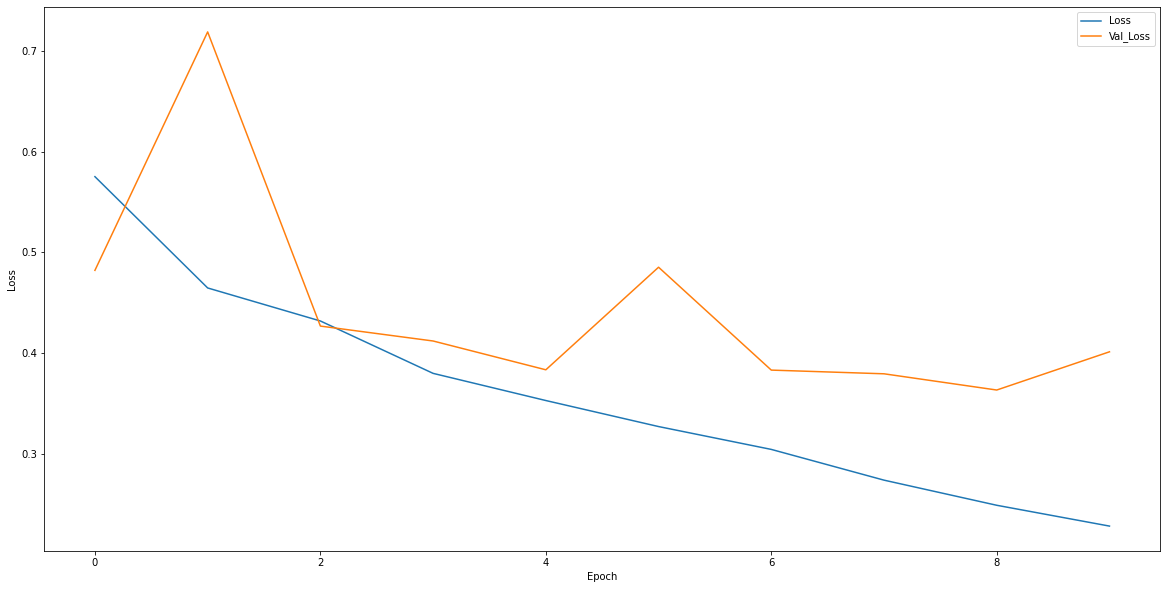

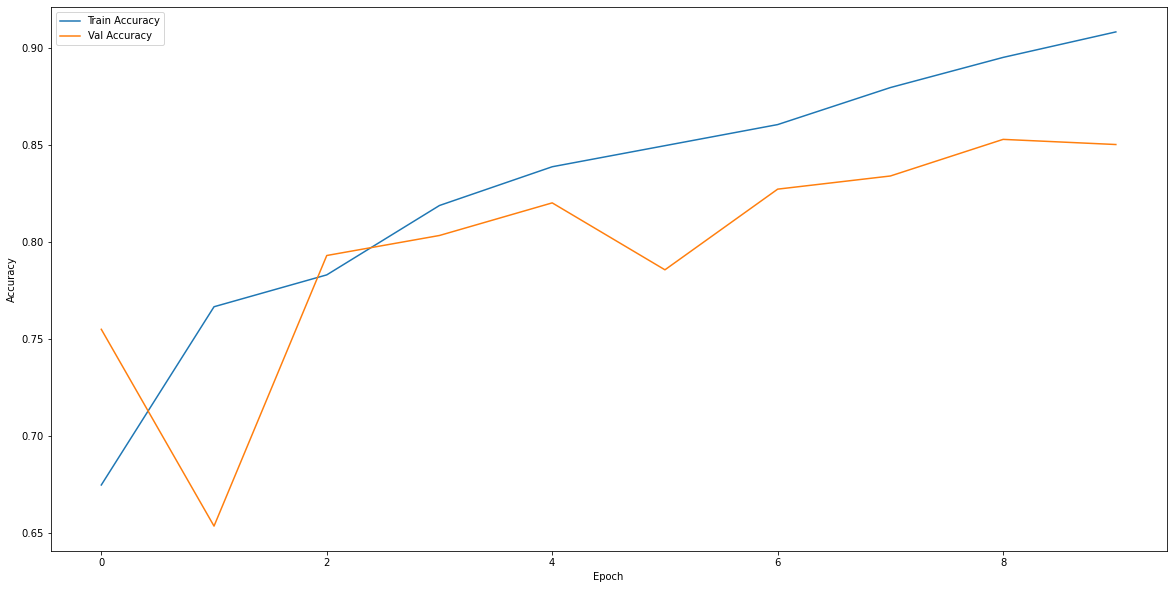

In [7]:
# Instantiating the network
conv_1 = Sequential()

# Adding convolutional layers
conv_1.add(layers.Conv2D(64, (2, 2), activation='relu', input_shape = (256, 256, 1)))
conv_1.add(layers.MaxPooling2D(2,2))
conv_1.add(layers.Conv2D(64, (2, 2), activation='relu'))
conv_1.add(layers.MaxPooling2D((2, 2)))
conv_1.add(layers.Conv2D(64, (2, 2), activation='relu'))
conv_1.add(layers.MaxPooling2D((2, 2)))
conv_1.add(layers.Conv2D(64, (2, 2), activation='relu'))
conv_1.add(layers.MaxPooling2D((2, 2)))
conv_1.add(layers.Conv2D(64, (2, 2), activation='relu'))
conv_1.add(layers.MaxPooling2D((2, 2)))

# Flattening in between convolutional and dense layers
conv_1.add(layers.Flatten())

# Adding dense hidden layers
conv_1.add(layers.Dense(64, activation='relu'))
conv_1.add(layers.Dense(64, activation='relu'))

# Final output layer
conv_1.add(layers.Dense(2, activation='softmax'))

# Compiling 
conv_1.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['acc'])

# Displaying a summary of the network's architecture
conv_1.summary()

# Fitting the network
conv_1_results = conv_1.fit(X_train, y_train,
                                epochs = 10,
                                batch_size = 32,
                                validation_data = (X_val, y_val))

# Graphing the learning curves 
graph_results(conv_1_results)

Due to the specialization of C.N.N.s for image processing tasks, this  first convolutional network is already surpassing the A.N.N.s in binary classifcation performance. It is clear however that after only a few epochs, the network begins to overfit the train set. To combat this, the next network iteration will employ regularization on its deep layers. The next network will also have additional units in its deep layers, in the hopes of increasing performance even further. 

### 3.3 Second Network

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 255, 255, 64)      320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 126, 126, 64)      16448     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 62, 62, 64)        16448     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 30, 30, 64)       

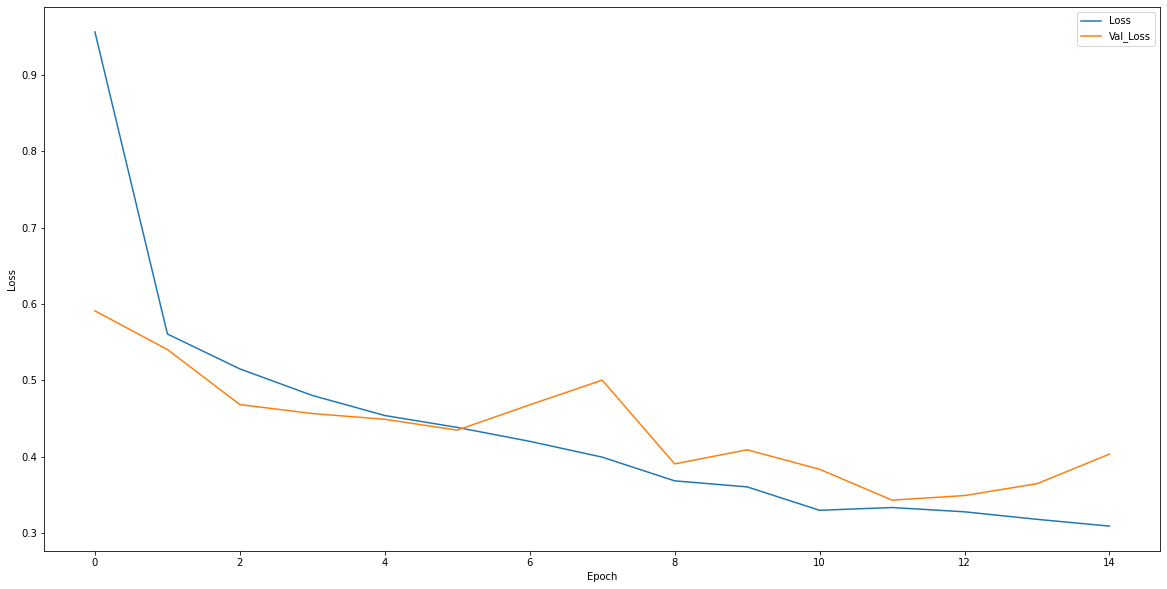

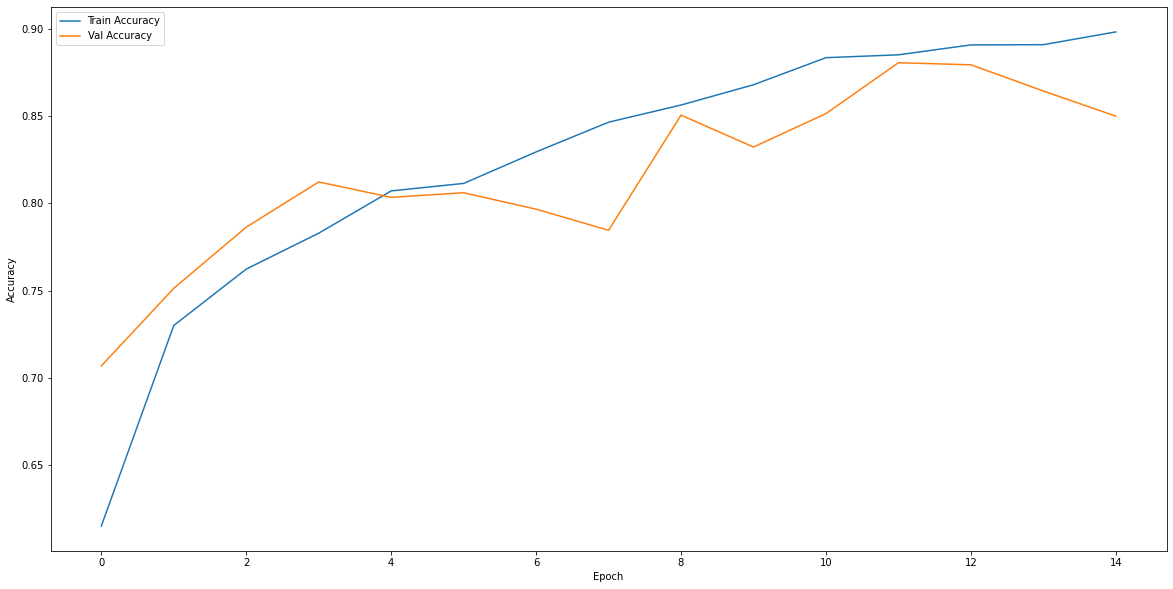

In [8]:
# Instantiating the network
conv_2 = Sequential()

# Adding convolutional layers
conv_2.add(layers.Conv2D(64, (2, 2), activation='relu', input_shape = (256, 256, 1)))
conv_2.add(layers.MaxPooling2D(2, 2))
conv_2.add(layers.Conv2D(64, (2, 2), activation='relu'))
conv_2.add(layers.MaxPooling2D((2, 2)))
conv_2.add(layers.Conv2D(64, (2, 2), activation='relu'))
conv_2.add(layers.MaxPooling2D((2, 2)))
conv_2.add(layers.Conv2D(64, (2, 2), activation='relu'))
conv_2.add(layers.MaxPooling2D((2, 2)))
conv_2.add(layers.Conv2D(64, (2, 2), activation='relu'))


# Flattening in between convolutional and dense layers
conv_2.add(layers.Flatten())

# Adding dense hidden layers
conv_2.add(layers.Dense(128, activation='relu', kernel_regularizer = l2(0.01)))
conv_2.add(layers.Dense(128, activation='relu', kernel_regularizer = l2(0.01)))

# Final output layer
conv_2.add(layers.Dense(2, activation='softmax'))

# Compiling 
conv_2.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['acc'])

# Displaying a summary of the network's architecture
conv_2.summary()

# Fitting the network
conv_2_results = conv_2.fit(X_train, y_train,
                                epochs = 15,
                                batch_size = 32,
                                validation_data = (X_val, y_val))
# Graphing the learning curves
graph_results(conv_2_results)

While it might have benefited from additional training epochs, the second network outperformed the first, and will be used in the final evaluation below. 

## 4. Network Evaluation for Binary Classification

Using the holdout set, which the model has never been trained or validated on, we will evaluate the performance of our C.N.N.s in the context of binary classification. 

In [9]:
f'Final Network Accuracy: {round(conv_2.evaluate(X_hold, y_hold)[1]* 100, 2)}%'

1257/1257 [==============================] - 11s 9ms/step


'Final Network Accuracy: 84.73%'

The convolutional networks outperformed the modeless baseline of 53% (guessing the majority class), and the performance of the 77% accuracy achieved by the artificial neural networks. The final iteration achieved an accuracy of 85%, a significant improvement. This jump in performance is of course due to the convolutional and pooling layers stacked before the deep layers, the attribute that make C.N.N.s so good at image classification tasks. This accuracy of 85% was achieved using 1257 holdout images for validation, however in terms of generalizability, this level of performance would likely only hold if future input images are similar in content and format. 

# Multiclass Classification with Convolutional Neural Network

## 1. Creating Multiclass Training Labels

Our image importing and proprocessing has already been done in cells above. 

In [4]:
# Instantiating an S3 filesystem object
fs = s3fs.S3FileSystem()

# Accessing our csv file from S3
csv = fs.open('s3://steel-training-dataset/train.csv')

# Tranforming it into a pandas dataframe
train_df = pd.read_csv(csv)

# Dropping duplicates, making this a multiclass problem instead of multilabel
train_df.drop_duplicates(['ImageId'], inplace=True)

# Displaying the first ten rows
train_df.head(10)

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...
5,0025bde0c.jpg,3,8458 14 8707 35 8963 48 9219 71 9475 88 9731 8...
7,002af848d.jpg,4,290800 6 291055 13 291311 15 291566 18 291822 ...
8,002fc4e19.jpg,1,146021 3 146275 10 146529 40 146783 46 147038 ...
10,0030401a5.jpg,4,186833 1 187089 3 187344 6 187600 7 187855 10 ...
11,0046839bd.jpg,3,152926 1 153180 4 153434 6 153689 8 153943 11 ...


In [5]:
# Making a list holding a filepath for every image in our training set 
path_list = fs.ls('s3://steel-training-dataset/training_images/train_images')

# This is a list all of our jpg filenames
filenames = [i.split('/')[-1] for i in path_list]

# Making a list of zeroes to use as the default label 
zeroes  = [0 for x in range(len(filenames))]

# This dictionary has the jpg names as keys, and zeroes as values 
label_dict = dict(zip(filenames, zeroes))

# Iterating through filenames and 
for i in filenames:
    if i in list(train_df.ImageId):
        label_dict[i] = list(train_df.loc[train_df['ImageId'] == i]['ClassId'])[0]

# Displaying the first ten elements of label_dict
list(label_dict.items())[:10]

[('0002cc93b.jpg', 1),
 ('00031f466.jpg', 0),
 ('000418bfc.jpg', 0),
 ('000789191.jpg', 0),
 ('0007a71bf.jpg', 3),
 ('000a4bcdd.jpg', 1),
 ('000f6bf48.jpg', 4),
 ('0014fce06.jpg', 3),
 ('001982b08.jpg', 0),
 ('001d1b355.jpg', 0)]

In [6]:
# Turning our target labels into an array 
multiclass_label_arr = list(label_dict.values())

# One hot encoding our binary labels
multiclass_labels = to_categorical(multiclass_label_arr)

# Sanity check
print(len(multiclass_labels))

# Displaying the first ten rows
multiclass_labels[:10]

12567


array([[0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

## 2. Train Test Splits

Because there is a new set of labels for multiclass classification, we will perform another round of train test splits. The motivations behind them are identical to above, and they will be using the same set of reshaped image arrays. The only difference is that the y will be the multiclass labels. 

In [7]:
# Split number 1: This holdout set wont return until the end of the notebook during evaluation
X_training, X_hold, y_training, y_hold = train_test_split(convolutional_arrays,
                                                          multiclass_labels,
                                                          random_state = seed,
                                                          test_size = .1)

In [8]:
# Split number 2: Train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_training, 
                                                  y_training,
                                                  random_state = seed,
                                                  test_size = .3)

## 3. Networks

Now that the images are processed, the label arrays have been created, and the data has been split, modeling can begin. 

### 3.1 First Network

This first network is an attempt to create the simplest possible network that can still learn the task. 

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 255, 255, 64)      320       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 126, 126, 64)      16448     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 62, 62, 64)        16448     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 30, 30, 64)       

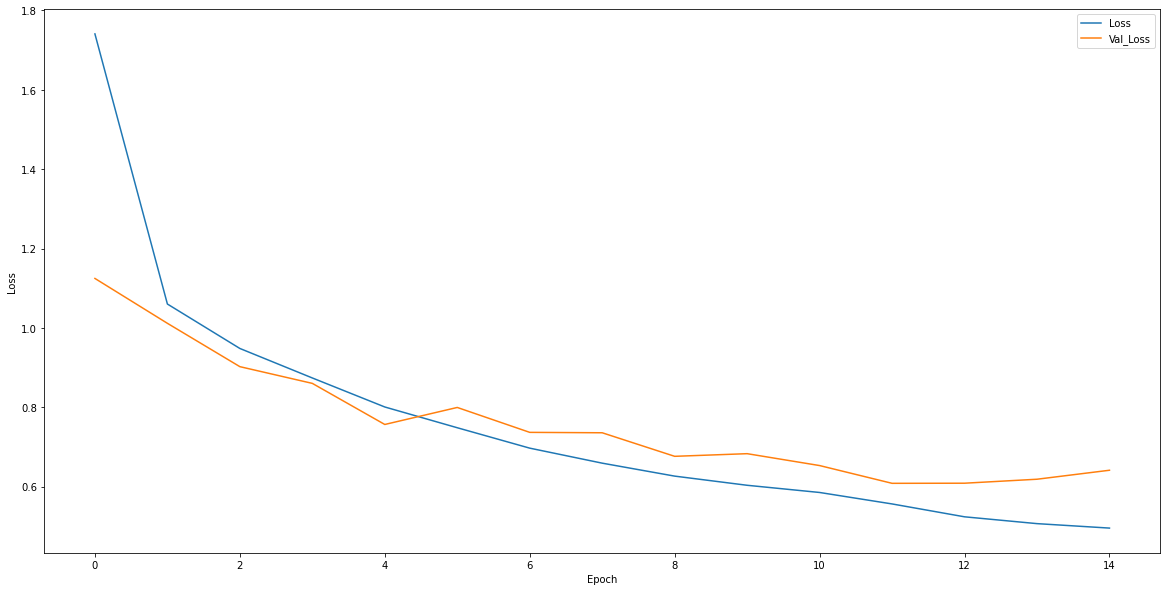

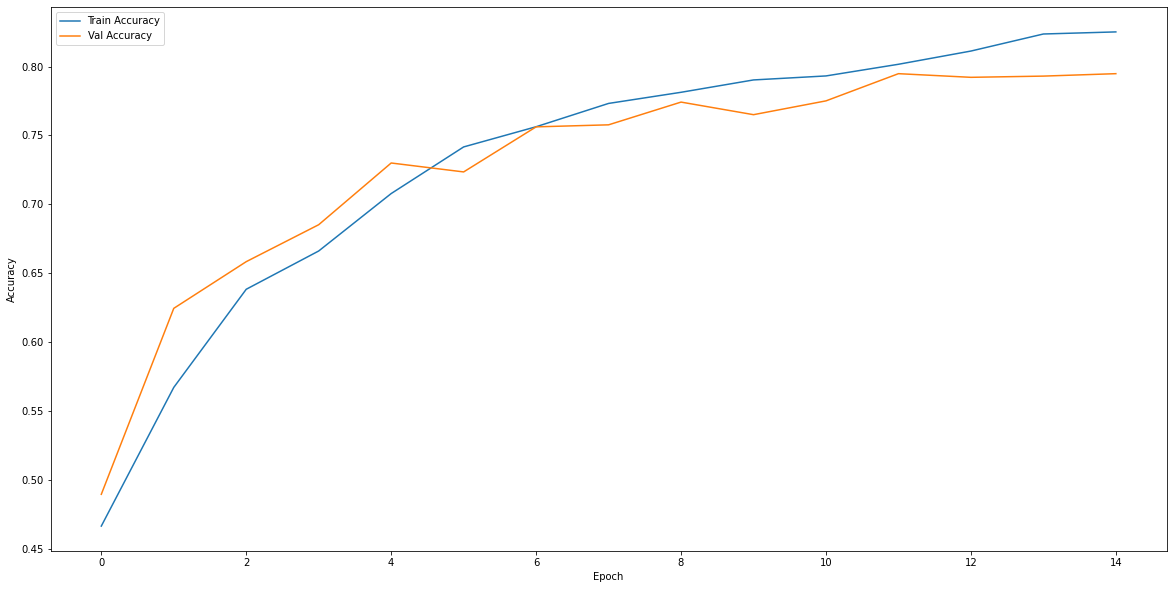

In [13]:
# Instantiating the network
conv_3 = Sequential()

# Adding convolutional layers
conv_3.add(layers.Conv2D(64, (2, 2), activation='relu', input_shape = (256, 256, 1)))
conv_3.add(layers.MaxPooling2D(2, 2))
conv_3.add(layers.Conv2D(64, (2, 2), activation='relu'))
conv_3.add(layers.MaxPooling2D((2, 2)))
conv_3.add(layers.Conv2D(64, (2, 2), activation='relu'))
conv_3.add(layers.MaxPooling2D((2, 2)))
conv_3.add(layers.Conv2D(64, (2, 2), activation='relu'))
conv_3.add(layers.MaxPooling2D((2, 2)))
conv_3.add(layers.Conv2D(64, (2, 2), activation='relu'))
conv_3.add(layers.MaxPooling2D((2, 2)))
conv_3.add(layers.Conv2D(64, (2, 2), activation='relu'))
conv_3.add(layers.MaxPooling2D((2, 2)))
conv_3.add(layers.Conv2D(64, (2, 2), activation='relu'))
conv_3.add(layers.MaxPooling2D((2, 2)))



# Flattening in between convolutional and dense layers
conv_3.add(layers.Flatten())

# Adding dense hidden layers
conv_3.add(layers.Dense(256, activation='relu', kernel_regularizer = l2(0.01)))
conv_3.add(layers.Dense(256, activation='relu', kernel_regularizer = l2(0.01)))


# Final output layer
conv_3.add(layers.Dense(5, activation='softmax'))

# Compiling 
conv_3.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['acc'])

# Displaying a summary of the network's architecture
conv_3.summary()

# Fitting the network
conv_3_results = conv_3.fit(X_train, y_train,
                                epochs = 15,
                                batch_size = 32,
                                validation_data = (X_val, y_val))
# Graphing the learning curves
graph_results(conv_3_results)

The first network is doing well, with smooth learning curves for both train and validation accuracy. The next model will have more deep layers, in the hope of improving performance. To keep compute time down, the next model will also have additional convolution and pooling layers. 

### 3.2 Second Network

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 255, 255, 64)      320       
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 126, 126, 64)      16448     
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 62, 62, 64)        16448     
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 30, 30, 64)       

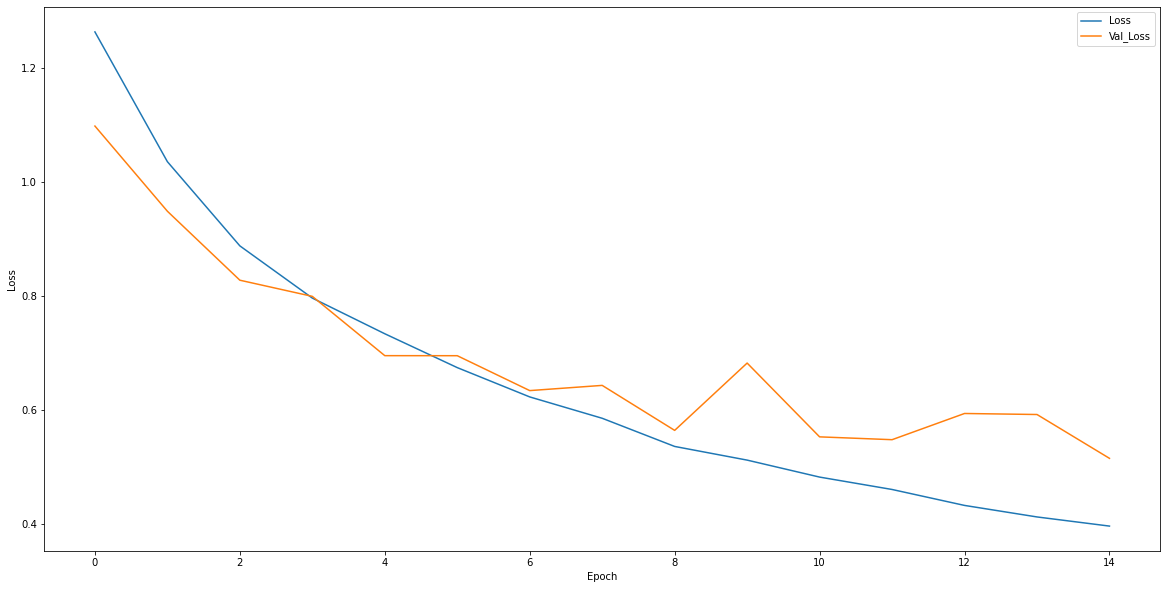

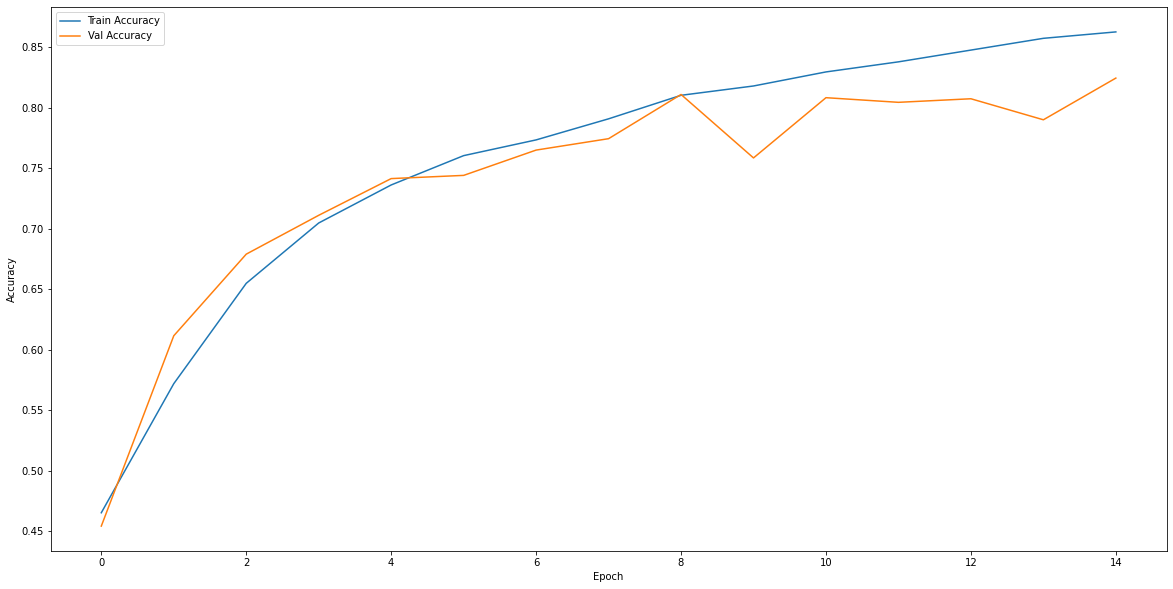

In [16]:
# Instantiating the network
conv_4 = Sequential()

# Adding convolutional layers
conv_4.add(layers.Conv2D(64, (2, 2), activation='relu', input_shape = (256, 256, 1)))
conv_4.add(layers.MaxPooling2D(2, 2))
conv_4.add(layers.Conv2D(64, (2, 2), activation='relu'))
conv_4.add(layers.MaxPooling2D((2, 2)))
conv_4.add(layers.Conv2D(64, (2, 2), activation='relu'))
conv_4.add(layers.MaxPooling2D((2, 2)))
conv_4.add(layers.Conv2D(64, (2, 2), activation='relu'))
conv_4.add(layers.MaxPooling2D((2, 2)))
conv_4.add(layers.Conv2D(64, (2, 2), activation='relu'))
conv_4.add(layers.MaxPooling2D((2, 2)))
conv_4.add(layers.Conv2D(64, (2, 2), activation='relu'))
conv_4.add(layers.MaxPooling2D((2, 2)))
conv_4.add(layers.Conv2D(64, (2, 2), activation='relu'))
conv_4.add(layers.MaxPooling2D((2, 2)))




# Flattening in between convolutional and dense layers
conv_4.add(layers.Flatten())

# Adding dense hidden layers
conv_4.add(layers.Dense(256, activation='relu', kernel_regularizer = l2(0.001)))
conv_4.add(layers.Dense(256, activation='relu', kernel_regularizer = l2(0.001)))
conv_4.add(layers.Dense(256, activation='relu', kernel_regularizer = l2(0.001)))


# Final output layer
conv_4.add(layers.Dense(5, activation='softmax'))

# Compiling 
conv_4.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['acc'])

# Displaying a summary of the network's architecture
conv_4.summary()

# Fitting the network
conv_4_results = conv_4.fit(X_train, y_train,
                                epochs = 15,
                                batch_size = 32,
                                validation_data = (X_val, y_val))
# Graphing the learning curves
graph_results(conv_4_results)

While this second model likely could benefit from additional training epochs, and an early stopping protocol, it is performing significantly better than the first. This model will be used in the final evaluation below. 

## 4. Network Evaluation for Multiclass Classification

In [17]:
f'Final Network Accuracy: {round(conv_3.evaluate(X_hold, y_hold)[1]* 100, 2)}%'

1257/1257 [==============================] - 11s 9ms/step


'Final Network Accuracy: 78.44%'

Despite the complexity of the task, and relatively short training period, the convolutional network managed 78.44% accuracy. 

# Conclusions

### Binary Classification with Convolutional Networks

When compared to a modeless baseline of 53%, and the 77% accuracy of the A.N.N., the 85% accuracy achieved by the convolutional network proves that it is the superior approach out of the three. The A.N.N.s simply dont hold up to the specialization of the C.N.N.s, and if binary classification is the deployment mode specified by the stakeholders, C.N.N.s are certainly a better choice of network architecture. 

### Multiclass Classification with Convolutional Networks

The deployment of a network capable of multiclass classification would largely be up to the manufacturing engineers, as domain knowledge about the various types of defects would determine how each piece was treated. It is easy to imagine however the various new options that multiclass classification would offer, over the simple defect or no defect output of binary classification. With an accuracy of roughly 79%, the network could even be trained for recall of certain classes of defect, if false negatives of that class is more intolerable. Severstal, the company behind this kaggle competition, have a clear interest in using machine learning to improve efficiency and lower costs, and this analysis proves that convolutional neural networks are a viable, and effective approach to achieving those goals. 